In [1]:
import albumentations as A
import cv2 as cv
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from albumentations.pytorch import ToTensorV2

from modules import *
from training import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
images = load_files_from_dir('../data/Drishti/ROI/TestImages')
masks = load_files_from_dir('../data/Drishti/ROI/TestMasks')
# images = load_files_from_dir('../data/ORIGA/ROI/TestImages')
# masks = load_files_from_dir('../data/ORIGA/ROI/TestMasks')

IMAGE_SIZE = 256
transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, interpolation=cv.INTER_AREA),
    A.CLAHE(p=1.0, clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
    ToTensorV2(),
])

# Reorder images and masks
indices = np.random.permutation(len(images))
images = [images[i] for i in indices]
masks = [masks[i] for i in indices]

loader = load_dataset(images, masks, transform, batch_size=1, shuffle=False, num_workers=4)

Loaded dataset with 51 samples in 51 batches.


In [5]:
checkpoint = load_checkpoint('./models/dual-refunet.pth')
model = checkpoint['model'].to(device)

=> Loading checkpoint: ./models/dual-refunet.pth


In [32]:
# store all the probabilities
results = []

model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(loader):
        images = images.to(device).float()
        masks = masks.to(device).long()

        od_outputs, oc_outputs = model(images)
        od_probs = torch.sigmoid(od_outputs)
        oc_probs = torch.sigmoid(oc_outputs)

        results.append((images, od_probs, oc_probs, masks))

print(len(results), results[0][0].shape, results[0][1].shape, results[0][2].shape, results[0][3].shape)

51 torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 256, 256])


In [155]:
thresholds = np.linspace(0, 1, 101)

tp_od = np.zeros_like(thresholds)
tn_od = np.zeros_like(thresholds)
fp_od = np.zeros_like(thresholds)
fn_od = np.zeros_like(thresholds)

tp_oc = np.zeros_like(thresholds)
tn_oc = np.zeros_like(thresholds)
fp_oc = np.zeros_like(thresholds)
fn_oc = np.zeros_like(thresholds)

for i, thresh in enumerate(thresholds):
    for j, (images, od_probs, oc_probs, masks) in enumerate(results):
        od_preds = (od_probs > thresh).long()
        oc_preds = (oc_probs > thresh).long()

        preds = torch.zeros_like(oc_preds)
        preds[od_preds == 1] = 1
        preds[oc_preds == 1] = 2

        met = get_metrics(masks, preds, [[1, 2], [2]])
        tp_od[i] += met['tp_OD']
        tn_od[i] += met['tn_OD']
        fp_od[i] += met['fp_OD']
        fn_od[i] += met['fn_OD']

        tp_oc[i] += met['tp_OC']
        tn_oc[i] += met['tn_OC']
        fp_oc[i] += met['fp_OC']
        fn_oc[i] += met['fn_OC']

from collections import defaultdict

metrics = defaultdict(lambda: np.zeros_like(thresholds))

for i, (tp, tn, fp, fn) in enumerate(zip(tp_od, tn_od, fp_od, fn_od)):
    met = calculate_metrics(tp, tn, fp, fn)
    for k, v in met.items():
        metrics[f'{k}_OD'][i] = v

for i, (tp, tn, fp, fn) in enumerate(zip(tp_oc, tn_oc, fp_oc, fn_oc)):
    met = calculate_metrics(tp, tn, fp, fn)
    for k, v in met.items():
        metrics[f'{k}_OC'][i] = v

df = pd.DataFrame({
    'threshold': thresholds,
    **metrics,
})
df['precision_OD'][100] = 1
df['precision_OC'][100] = 1
df

,threshold,accuracy_OD,precision_OD,npv_OD,sensitivity_OD,specificity_OD,fpr_OD,fnr_OD,dice_OD,iou_OD,...,fpr_OC,fnr_OC,dice_OC,iou_OC,balance_accuracy_OC,f1_OC,tp_OC,tn_OC,fp_OC,fn_OC
0,0.00,0.256932,0.256932,0.000000,1.000000,0.000000,1.000000,0.000000,0.408824,0.256932,...,1.000000,0.000000,0.247710,0.141364,0.500000,0.247710,472485.0,0.0,2869851.0,0.0
1,0.01,0.604377,0.393607,0.998902,0.998512,0.468096,0.531904,0.001488,0.564638,0.393376,...,0.058557,0.031836,0.833247,0.714159,0.954804,0.833247,457443.0,2701802.0,168049.0,15042.0
2,0.02,0.947403,0.835937,0.996118,0.989485,0.932852,0.067148,0.010515,0.906253,0.828577,...,0.043478,0.058207,0.853894,0.745039,0.949157,0.853894,444983.0,2745075.0,124776.0,27502.0
3,0.03,0.965591,0.895677,0.992941,0.980252,0.960522,0.039478,0.019748,0.936058,0.879801,...,0.036530,0.078650,0.859775,0.754040,0.942410,0.859775,435324.0,2765014.0,104837.0,37161.0
4,0.04,0.973072,0.926053,0.990456,0.972879,0.973138,0.026862,0.027121,0.948889,0.902748,...,0.032005,0.095887,0.861672,0.756963,0.936054,0.861672,427180.0,2778002.0,91849.0,45305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.947883,0.998033,0.934902,0.798730,0.999456,0.000544,0.201270,0.887328,0.797474,...,0.002160,0.545245,0.619610,0.448866,0.726298,0.619610,214865.0,2863652.0,6199.0,257620.0
97,0.97,0.943432,0.998624,0.929555,0.780909,0.999628,0.000372,0.219091,0.876448,0.780069,...,0.001652,0.580054,0.587344,0.415773,0.709147,0.587344,198418.0,2865109.0,4742.0,274067.0
98,0.98,0.936100,0.999180,0.920980,0.751912,0.999787,0.000213,0.248088,0.858088,0.751448,...,0.001155,0.627387,0.540163,0.370016,0.685729,0.540163,176054.0,2866535.0,3316.0,296431.0
99,0.99,0.920650,0.999720,0.903564,0.691354,0.999933,0.000067,0.308646,0.817422,0.691221,...,0.000574,0.701311,0.458753,0.297651,0.649057,0.458753,141126.0,2868203.0,1648.0,331359.0


Best threshold for OD: 0.09
Best threshold for OC: 0.04


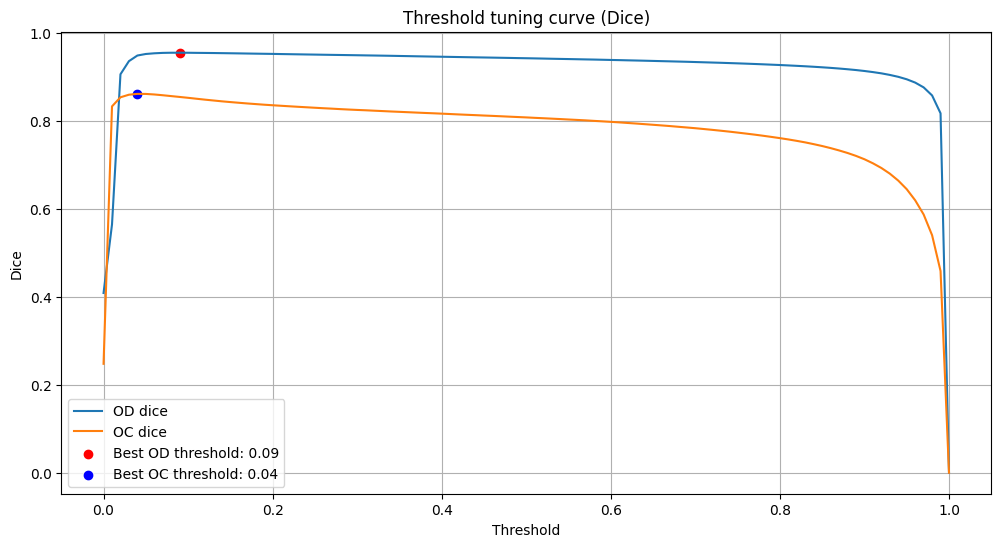

In [171]:
od_best_dice_index = df['dice_OD'].idxmax()
oc_best_dice_index = df['dice_OC'].idxmax()

best_threshold_od = df['threshold'][od_best_dice_index]
best_threshold_oc = df['threshold'][oc_best_dice_index]

print(f'Best threshold for OD: {best_threshold_od:.2f}')
print(f'Best threshold for OC: {best_threshold_oc:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(df['threshold'], df['dice_OD'], label='OD dice')
plt.plot(df['threshold'], df['dice_OC'], label='OC dice')
plt.scatter(df['threshold'][od_best_dice_index], df['dice_OD'][od_best_dice_index],
            c='r', label=f'Best OD threshold: {best_threshold_od:.2f}')
plt.scatter(df['threshold'][oc_best_dice_index], df['dice_OC'][oc_best_dice_index],
            c='b', label=f'Best OC threshold: {best_threshold_oc:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Dice')
plt.title('Threshold tuning curve (Dice)')
plt.legend()
plt.grid(True)
plt.show()

Best threshold for OD: 0.04
Best threshold for OC: 0.01


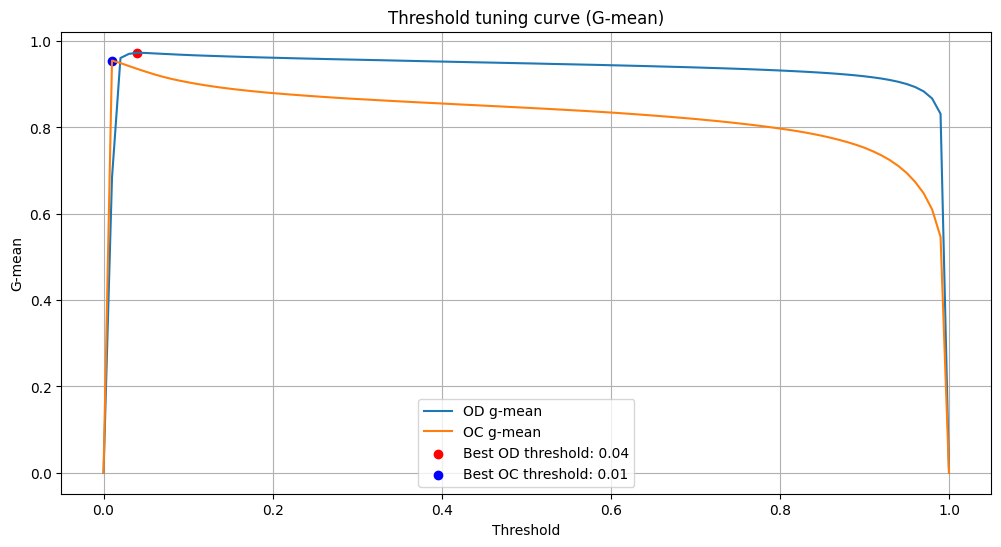

In [172]:
od_gmean = np.sqrt(df['sensitivity_OD'] * df['specificity_OD'])
oc_gmean = np.sqrt(df['sensitivity_OC'] * df['specificity_OC'])

od_best_gmean_index = od_gmean.idxmax()
oc_best_gmean_index = oc_gmean.idxmax()

best_threshold_od = df['threshold'][od_best_gmean_index]
best_threshold_oc = df['threshold'][oc_best_gmean_index]

print(f'Best threshold for OD: {best_threshold_od:.2f}')
print(f'Best threshold for OC: {best_threshold_oc:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(df['threshold'], od_gmean, label='OD g-mean')
plt.plot(df['threshold'], oc_gmean, label='OC g-mean')
plt.scatter(df['threshold'][od_best_gmean_index], od_gmean[od_best_gmean_index],
            c='r', label=f'Best OD threshold: {best_threshold_od:.2f}')
plt.scatter(df['threshold'][oc_best_gmean_index], oc_gmean[oc_best_gmean_index],
            c='b', label=f'Best OC threshold: {best_threshold_oc:.2f}')
plt.xlabel('Threshold')
plt.ylabel('G-mean')
plt.title('Threshold tuning curve (G-mean)')
plt.legend()
plt.grid(True)
plt.show()

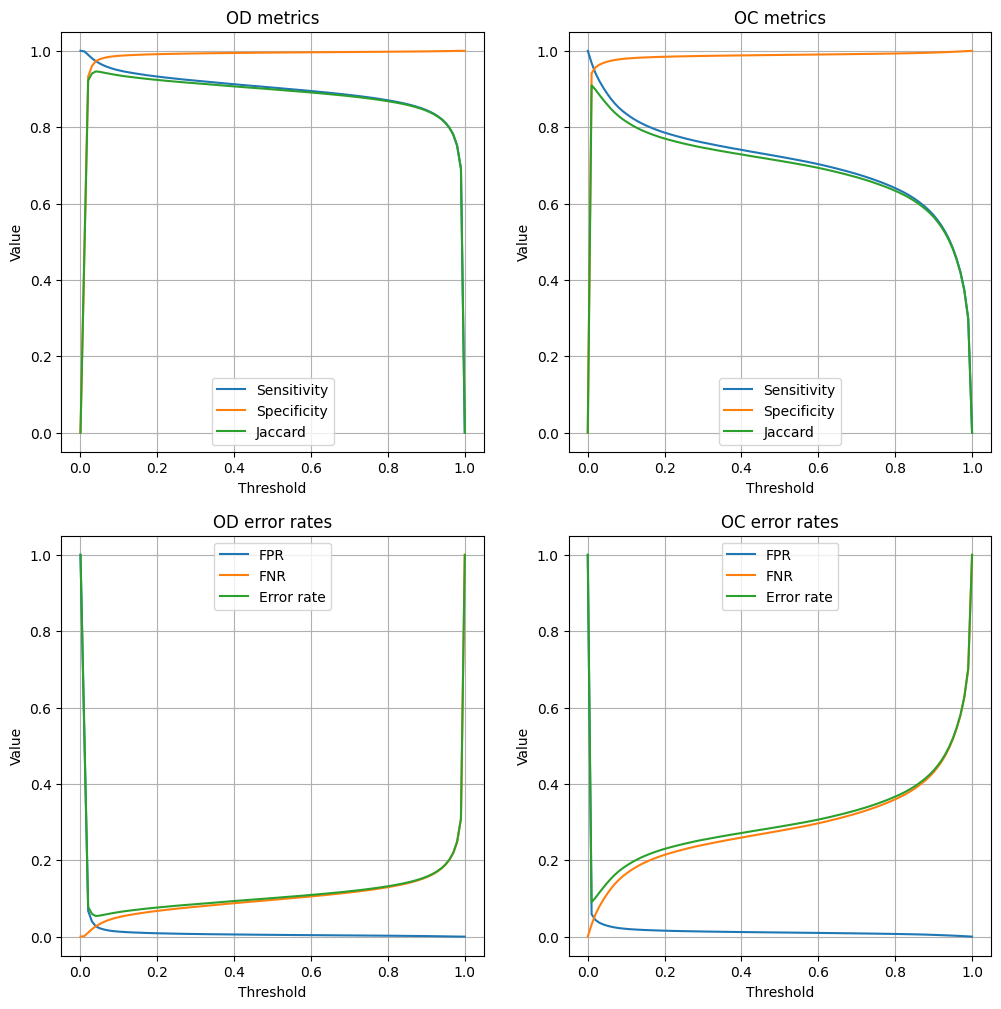

In [161]:
# Plot metrics
_, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].plot(df['threshold'], df['sensitivity_OD'], label='Sensitivity')
ax[0, 0].plot(df['threshold'], df['specificity_OD'], label='Specificity')
ax[0, 0].plot(df['threshold'], df['specificity_OD'] + df['sensitivity_OD'] - 1, label='Jaccard')
ax[0, 0].set_xlabel('Threshold')
ax[0, 0].set_ylabel('Value')
ax[0, 0].set_title('OD metrics')
ax[0, 0].legend()
ax[0, 0].grid(True)

ax[0, 1].plot(df['threshold'], df['sensitivity_OC'], label='Sensitivity')
ax[0, 1].plot(df['threshold'], df['specificity_OC'], label='Specificity')
ax[0, 1].plot(df['threshold'], df['specificity_OC'] + df['sensitivity_OC'] - 1, label='Jaccard')
ax[0, 1].set_xlabel('Threshold')
ax[0, 1].set_ylabel('Value')
ax[0, 1].set_title('OC metrics')
ax[0, 1].legend()
ax[0, 1].grid(True)

ax[1, 0].plot(df['threshold'], df['fpr_OD'], label='FPR')
ax[1, 0].plot(df['threshold'], df['fnr_OD'], label='FNR')
ax[1, 0].plot(df['threshold'], df['fpr_OD'] + df['fnr_OD'], label='Error rate')
ax[1, 0].set_xlabel('Threshold')
ax[1, 0].set_ylabel('Value')
ax[1, 0].set_title('OD error rates')
ax[1, 0].legend()
ax[1, 0].grid(True)

ax[1, 1].plot(df['threshold'], df['fpr_OC'], label='FPR')
ax[1, 1].plot(df['threshold'], df['fnr_OC'], label='FNR')
ax[1, 1].plot(df['threshold'], df['fpr_OC'] + df['fnr_OC'], label='Error rate')
ax[1, 1].set_xlabel('Threshold')
ax[1, 1].set_ylabel('Value')
ax[1, 1].set_title('OC error rates')
ax[1, 1].legend()
ax[1, 1].grid(True)

plt.show()

Best threshold for OD: 0.04
Best threshold for OC: 0.01


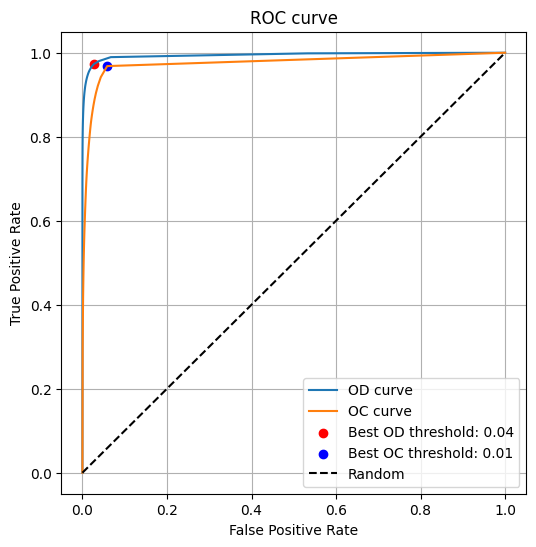

In [158]:
# ROC curve
od_distances = np.sqrt(df['fpr_OD'] ** 2 + (1 - df['sensitivity_OD']) ** 2)
oc_distances = np.sqrt(df['fpr_OC'] ** 2 + (1 - df['sensitivity_OC']) ** 2)

min_index_od = od_distances.idxmin()
min_index_oc = oc_distances.idxmin()

best_threshold_od = df['threshold'][min_index_od]
best_threshold_oc = df['threshold'][min_index_oc]

print(f'Best threshold for OD: {best_threshold_od:.2f}')
print(f'Best threshold for OC: {best_threshold_oc:.2f}')

plt.figure(figsize=(6, 6))
plt.plot(df['fpr_OD'], df['sensitivity_OD'], label='OD curve')
plt.plot(df['fpr_OC'], df['sensitivity_OC'], label='OC curve')
plt.scatter(df['fpr_OD'][min_index_od], df['sensitivity_OD'][min_index_od],
            c='r', label=f'Best OD threshold: {best_threshold_od:.2f}')
plt.scatter(df['fpr_OC'][min_index_oc], df['sensitivity_OC'][min_index_oc],
            c='b', label=f'Best OC threshold: {best_threshold_oc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.grid(True)
plt.show()

Best threshold for OD: 0.08
Best threshold for OC: 0.05


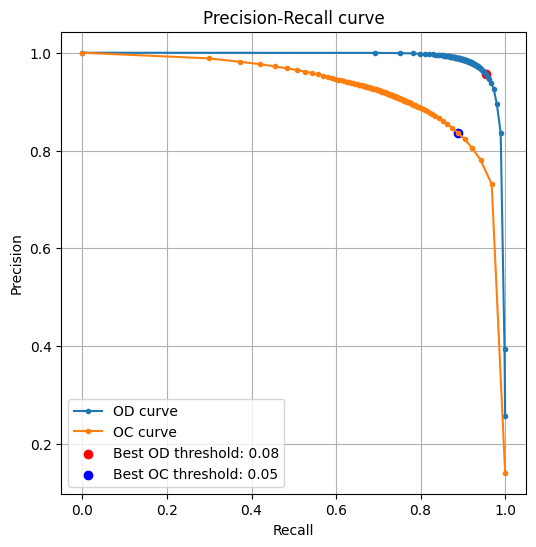

In [169]:
# Precision-Recall curve
precision_od = df['precision_OD']
recall_od = df['sensitivity_OD']
precision_oc = df['precision_OC']
recall_oc = df['sensitivity_OC']

od_distances = np.sqrt((1 - precision_od) ** 2 + (1 - recall_od) ** 2)
oc_distances = np.sqrt((1 - precision_oc) ** 2 + (1 - recall_oc) ** 2)

min_index_od = od_distances.idxmin()
min_index_oc = oc_distances.idxmin()

best_threshold_od = df['threshold'][min_index_od]
best_threshold_oc = df['threshold'][min_index_oc]

print(f'Best threshold for OD: {best_threshold_od:.2f}')
print(f'Best threshold for OC: {best_threshold_oc:.2f}')

plt.figure(figsize=(6, 6))
plt.plot(recall_od, precision_od, label='OD curve', marker='.')
plt.plot(recall_oc, precision_oc, label='OC curve', marker='.')
plt.scatter(recall_od[min_index_od], precision_od[min_index_od],
            c='r', label=f'Best OD threshold: {best_threshold_od:.2f}')
plt.scatter(recall_oc[min_index_oc], precision_oc[min_index_oc],
            c='b', label=f'Best OC threshold: {best_threshold_oc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.grid(True)
plt.show()

In [168]:
evaluate('dual', model, loader, device, thresh=0.05)

Evaluating: 100%|██████████| 51/51 [00:07<00:00,  6.49it/s, accuracy_OC=0.959, accuracy_OD=0.974, balance_accuracy_OC=0.94, balance_accuracy_OD=0.973, dice_OC=0.843, dice_OD=0.948, f1_OC=0.843, f1_OD=0.948, fn_OC=1.05e+3, fn_OD=614, fnr_OC=0.0921, fnr_OD=0.0316, fp_OC=1.64e+3, fp_OD=1.12e+3, fpr_OC=0.0276, fpr_OD=0.0222, iou_OC=0.747, iou_OD=0.903, npv_OC=0.981, npv_OD=0.986, precision_OC=0.835, precision_OD=0.932, sensitivity_OC=0.908, sensitivity_OD=0.968, specificity_OC=0.972, specificity_OD=0.978, tn_OC=5.46e+4, tn_OD=4.76e+4, tp_OC=8.22e+3, tp_OD=1.62e+4]


{'accuracy_OD': 0.9735616048177084,
 'precision_OD': 0.9323981964871001,
 'npv_OD': 0.9863341160299575,
 'sensitivity_OD': 0.9683853377229945,
 'specificity_OD': 0.9777787395380836,
 'fpr_OD': 0.02222126046191625,
 'fnr_OD': 0.03161466227700551,
 'dice_OD': 0.9478735004857077,
 'iou_OD': 0.9026090162892441,
 'balance_accuracy_OD': 0.9730820386305391,
 'f1_OD': 0.9478735004857075,
 'tp_OD': 16224.411764705883,
 'tn_OD': 47578.92156862745,
 'fp_OD': 1118.8039215686274,
 'fn_OD': 613.8627450980392,
 'accuracy_OC': 0.9590445125804228,
 'precision_OC': 0.8349029266599349,
 'npv_OC': 0.9809966665098424,
 'sensitivity_OC': 0.9078692183171755,
 'specificity_OC': 0.9724271211235189,
 'fpr_OC': 0.027572878876481112,
 'fnr_OC': 0.09213078168282436,
 'dice_OC': 0.8433239805030293,
 'iou_OC': 0.7472963226110173,
 'balance_accuracy_OC': 0.9401481697203473,
 'f1_OC': 0.8433239805030293,
 'tp_OC': 8218.588235294117,
 'tn_OC': 54633.35294117647,
 'fp_OC': 1638.235294117647,
 'fn_OC': 1045.8235294117646

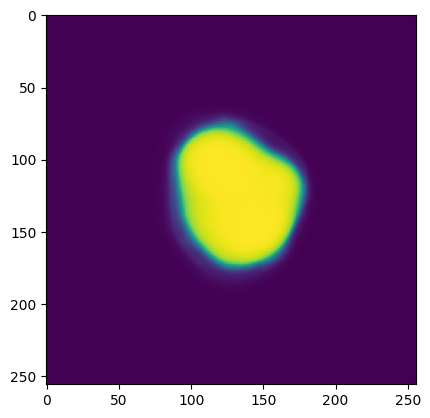

In [160]:
img = results[30][2].squeeze().cpu().numpy()
plt.imshow(img)
plt.show()

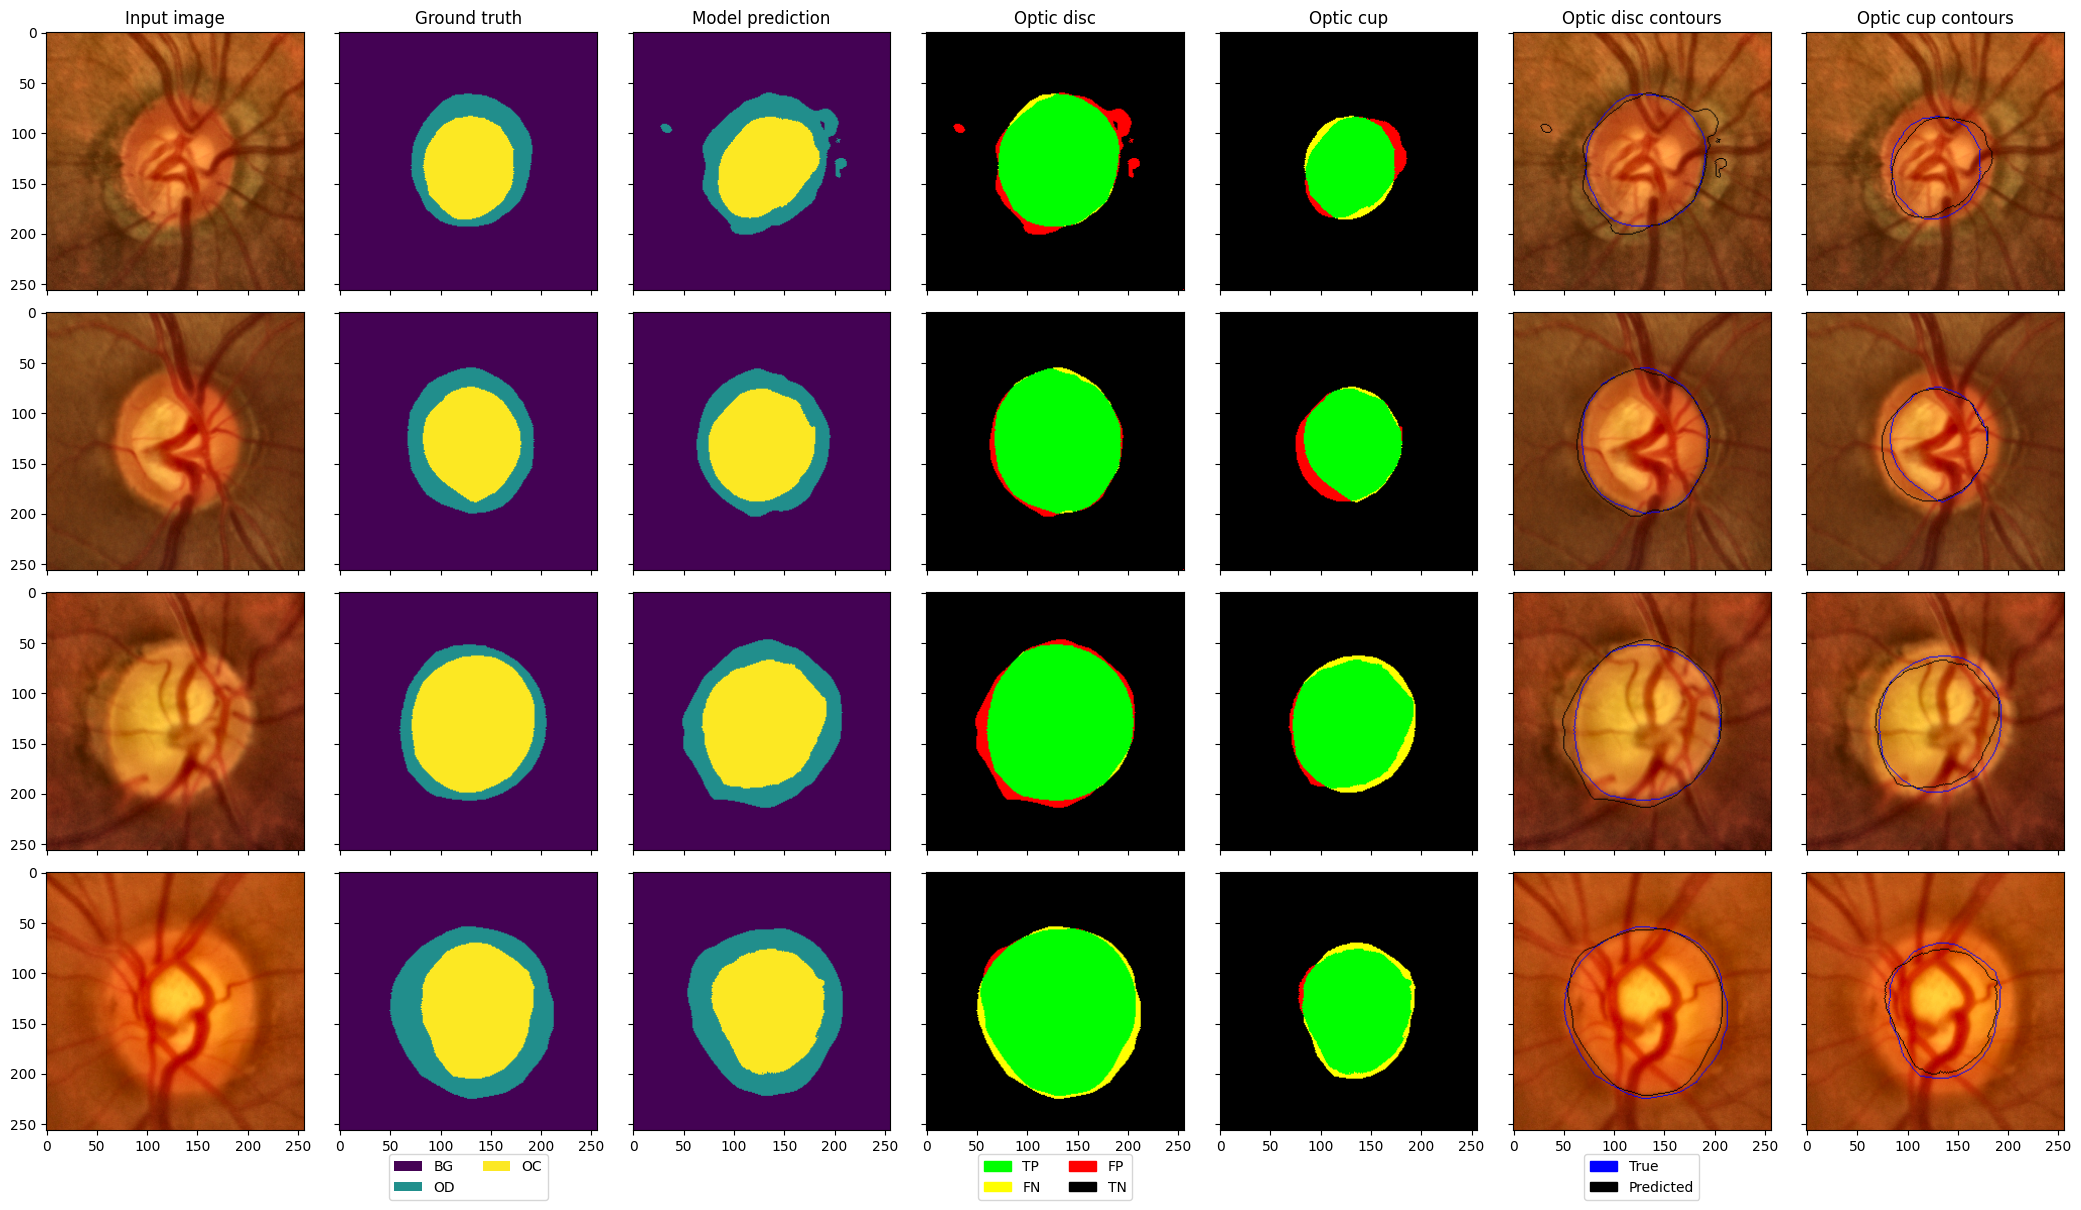

In [147]:
plot_results_from_loader('dual', loader, model, device, n_samples=4, thresh=0.05)

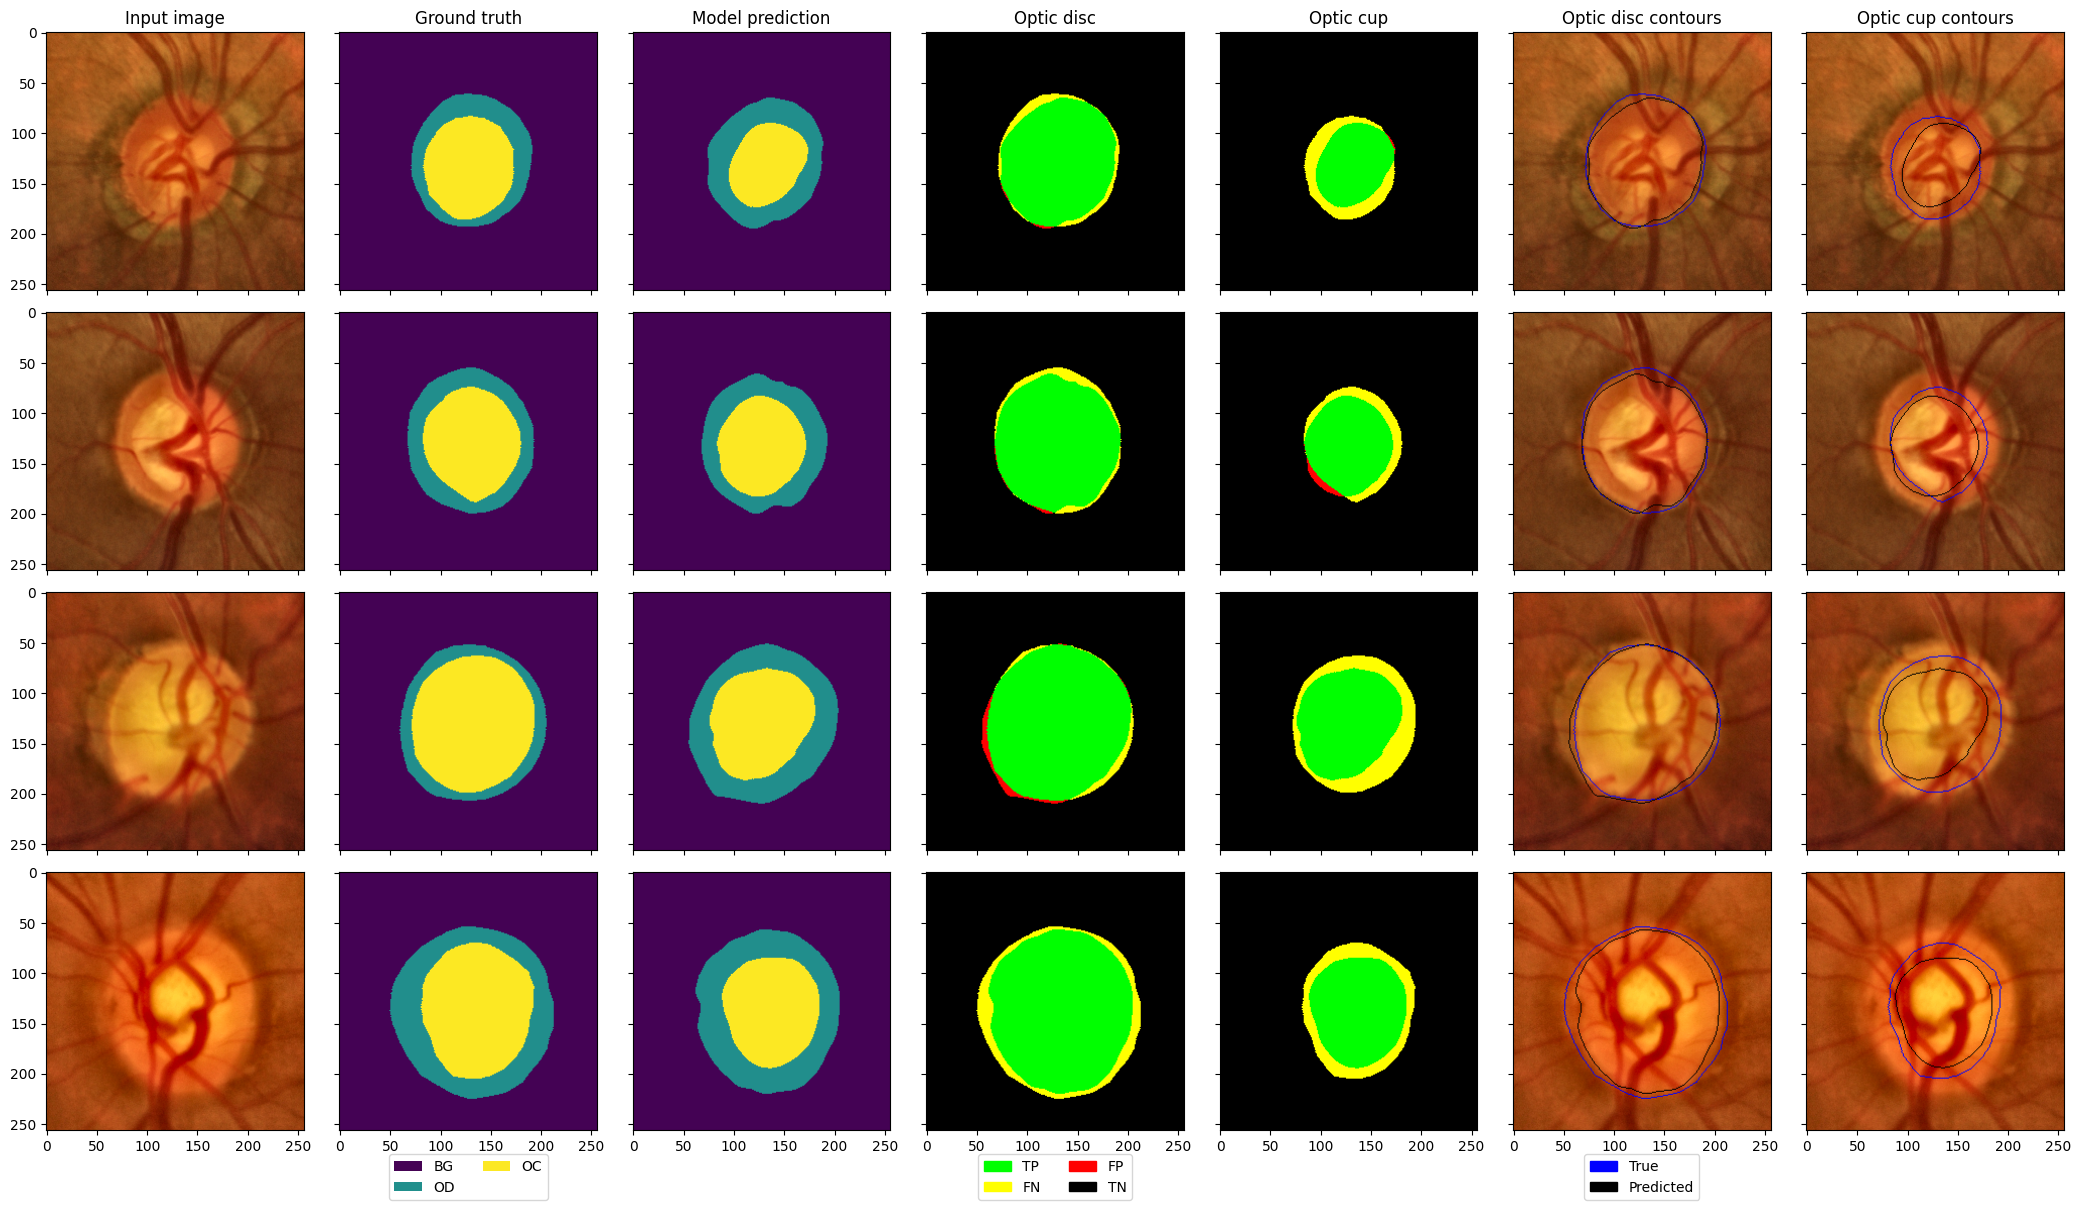

In [148]:
plot_results_from_loader('dual', loader, model, device, n_samples=4, thresh=0.5)

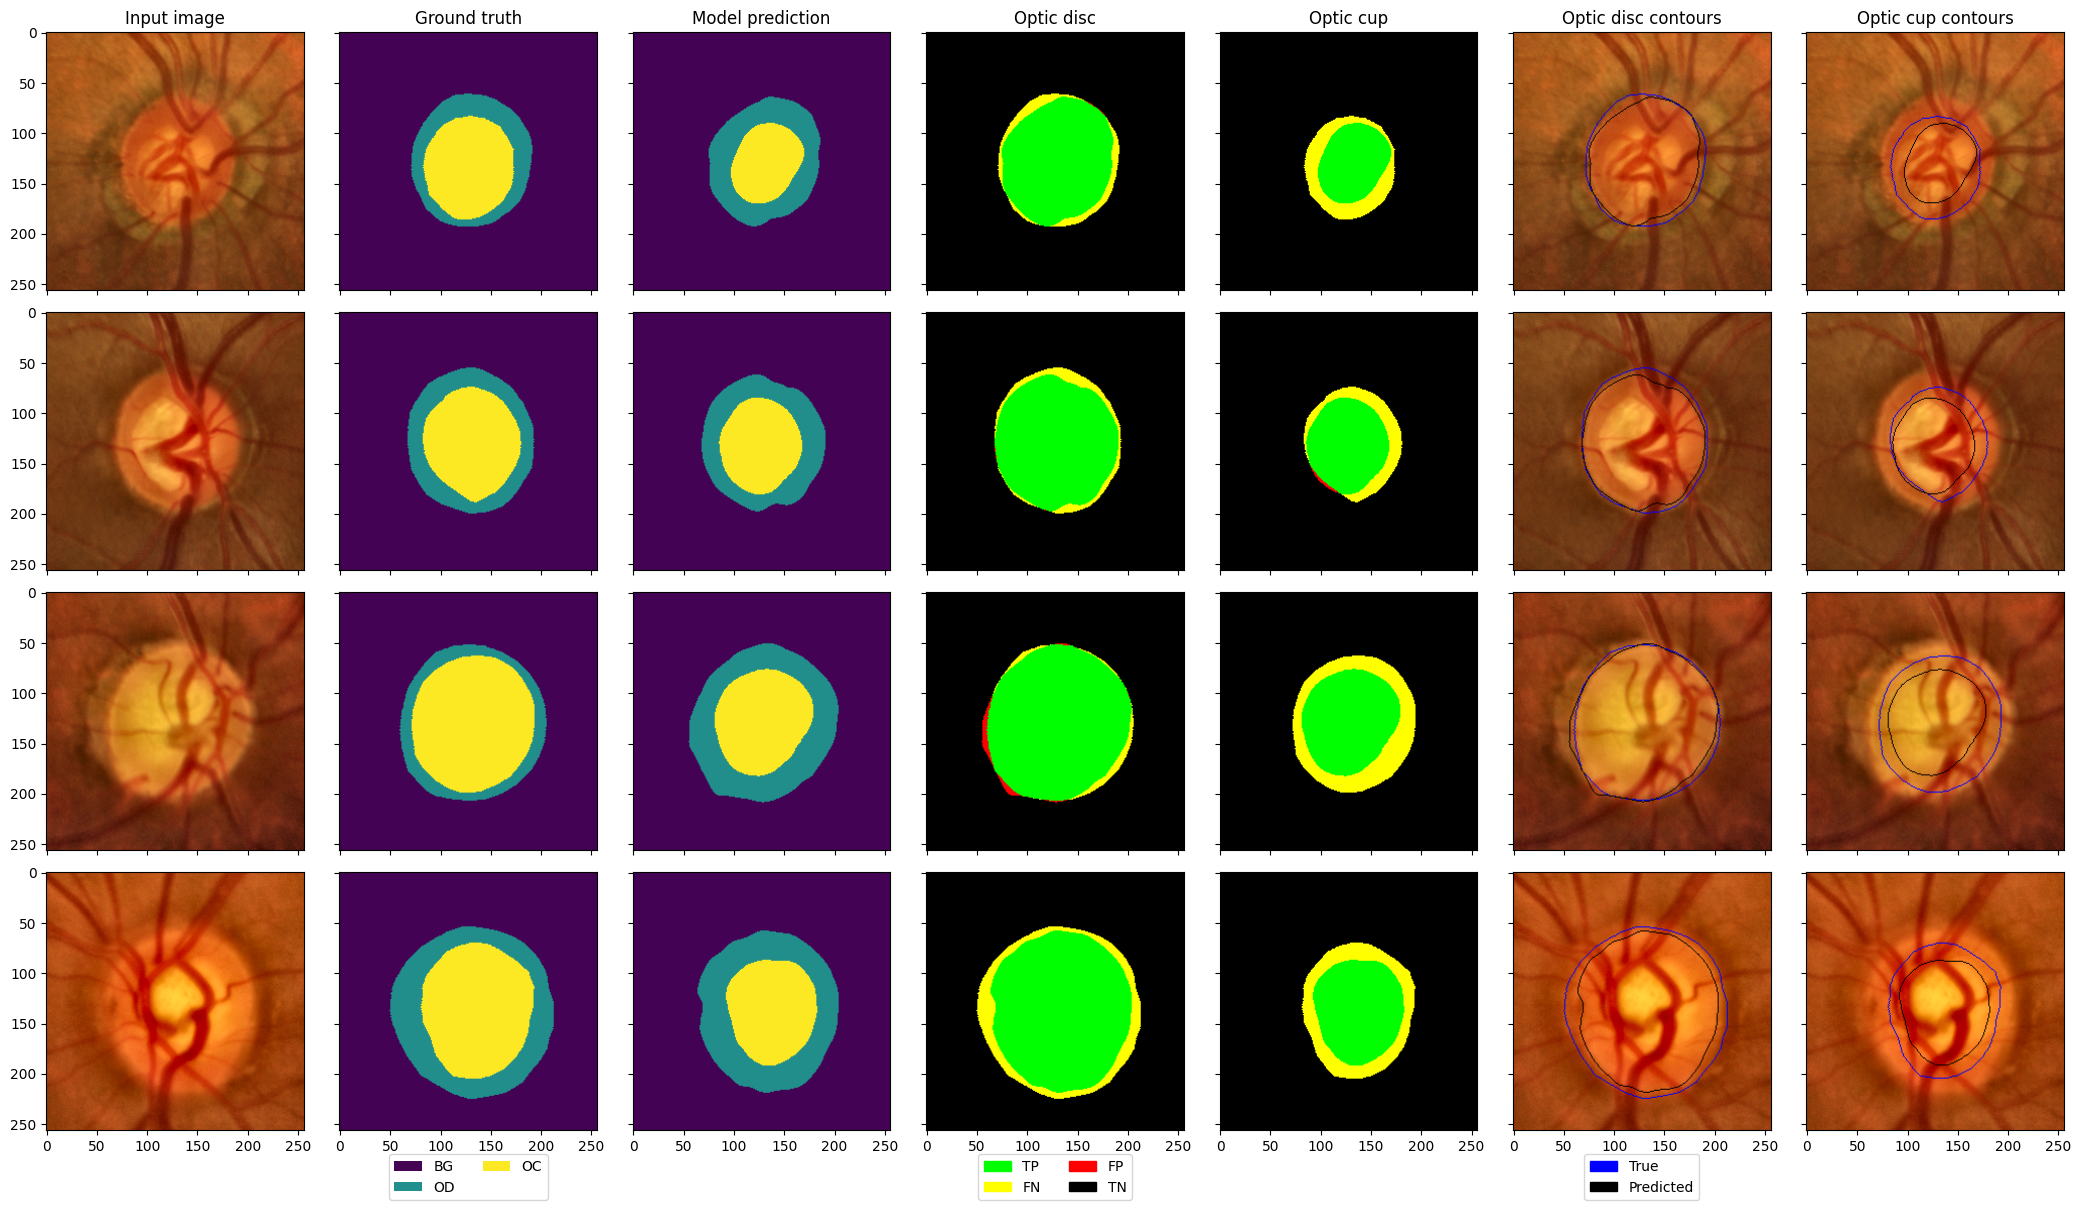

In [149]:
plot_results_from_loader('dual', loader, model, device, n_samples=4, thresh=0.8)

In [17]:
checkpoint = load_checkpoint('./models/dual-refunet.pth', map_location=device)
dual_model = checkpoint['model'].to(device)

=> Loading checkpoint: ./models/dual-refunet.pth


torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 2, 256, 256]) tensor(0.2741, device='cuda:0')


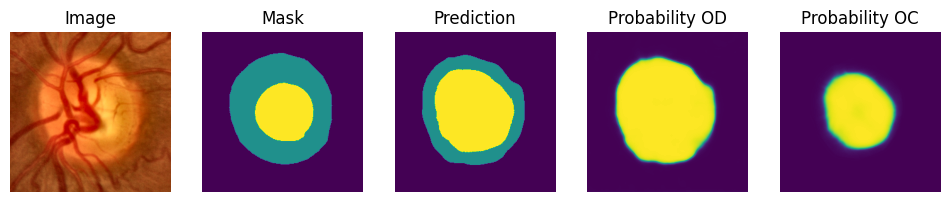

In [8]:
model = dual_model
criterion = ComboLoss(1)

for images, masks in loader:
    images, masks = images.float(), masks.long()
    print(images.shape, masks.shape)
    preds, probs, loss = predict_dual(model, images, masks, device, criterion, od_threshold=0.1, oc_threshold=0.05)
    print(preds.shape, probs.shape, loss)

    for i in range(images.shape[0]):
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        mask = masks[i].detach().cpu().numpy()
        pred = preds[i].detach().cpu().numpy()
        prob = probs[i].detach().cpu().numpy()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 5, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(pred)
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(prob[0])
        plt.title('Probability OD')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(prob[1])
        plt.title('Probability OC')
        plt.axis('off')

        plt.show()
    break

In [4]:
checkpoint = load_checkpoint('./models/binary-raunet.pth', map_location=device)
binary_model = checkpoint['model'].to(device)

checkpoint = load_checkpoint('./models/cascade-raunet.pth', map_location=device)
cascade_model = checkpoint['model'].to(device)

=> Loading checkpoint: ./models/binary-raunet.pth
=> Loading checkpoint: ./models/cascade-raunet.pth


torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) tensor(0.0300, device='cuda:0')


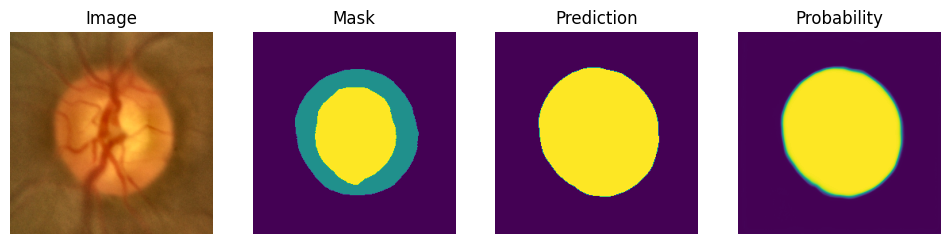

In [54]:
model = binary_model
criterion = ComboLoss(1)

for images, masks in loader:
    images, masks = images.float(), masks.long()
    print(images.shape, masks.shape)
    preds, probs, loss = predict_binary(model, images, masks, device, criterion, threshold=0.5)
    print(preds.shape, probs.shape, loss)

    for i in range(images.shape[0]):
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        mask = masks[i].detach().cpu().numpy()
        pred = preds[i].detach().cpu().numpy()
        prob = probs[i].detach().cpu().numpy()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(pred)
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(prob)
        plt.title('Probability')
        plt.axis('off')

        plt.show()
    break


torch.Size([1, 3, 256, 256]) torch.Size([1, 256, 256])
torch.Size([1, 256, 256]) torch.Size([1, 2, 256, 256]) tensor(0.4571, device='cuda:0')


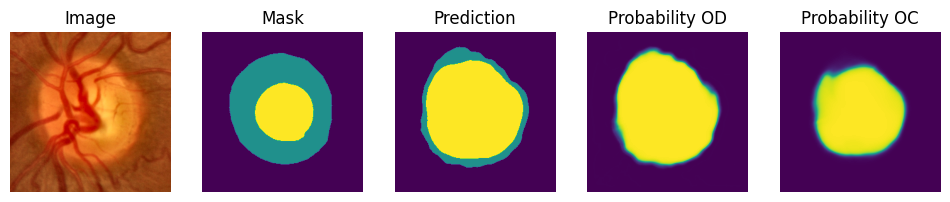

In [10]:
model = cascade_model
criterion = ComboLoss(1)

for images, masks in loader:
    images, masks = images.float(), masks.long()
    print(images.shape, masks.shape)
    preds, probs, loss = predict_cascade(binary_model, model, images, masks, device, criterion,
                                         od_threshold=0.1, oc_threshold=0.05)
    print(preds.shape, probs.shape, loss)

    for i in range(images.shape[0]):
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        mask = masks[i].detach().cpu().numpy()
        pred = preds[i].detach().cpu().numpy()
        prob = probs[i].detach().cpu().numpy()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 5, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(pred)
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(prob[0])
        plt.title('Probability OD')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(prob[1])
        plt.title('Probability OC')
        plt.axis('off')

        plt.show()
    break

In [7]:
checkpoint = load_checkpoint('./models/best-multiclass-RefUnet3PlusCBAM-model.pth', map_location=device)
multiclass_model = checkpoint['model'].to(device)

checkpoint = load_checkpoint('./models/best-multilabel-RefUnet3PlusCBAM-model.pth', map_location=device)
multilabel_model = checkpoint['model'].to(device)

=> Loading checkpoint: ./models/best-multiclass-RefUnet3PlusCBAM-model.pth
=> Loading checkpoint: ./models/best-multilabel-RefUnet3PlusCBAM-model.pth


In [25]:
images = load_files_from_dir('../data/ORIGA/ROI/TrainImages')
masks = load_files_from_dir('../data/ORIGA/ROI/TrainMasks')

transform = A.Compose([
    A.Resize(height=128, width=128, interpolation=cv.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    A.CLAHE(p=1.0, clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomToneCurve(p=0.5),
    A.MultiplicativeNoise(p=0.5),
    A.Lambda(image=sharpen, p=1.0),
    A.Normalize(),
    ToTensorV2(),
])

loader2 = load_dataset(images, masks, transform, batch_size=1, shuffle=False, num_workers=4)

Loaded dataset with 325 samples in 325 batches.


torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128]) tensor(0.5113, device='cuda:0')


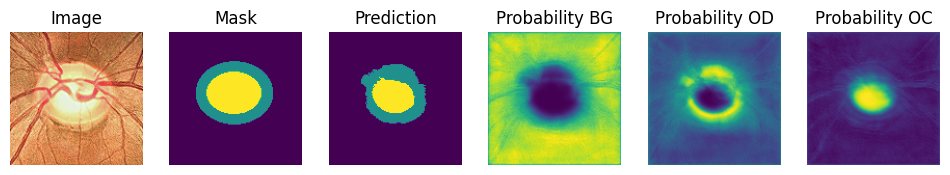

In [26]:
model = multiclass_model
criterion = ComboLoss(3)

for images, masks in loader2:
    images, masks = images.float(), masks.long()
    print(images.shape, masks.shape)
    preds, probs, loss = predict_multiclass(model, images, masks, device, criterion)
    print(preds.shape, probs.shape, loss)

    for i in range(images.shape[0]):
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        mask = masks[i].detach().cpu().numpy()
        pred = preds[i].detach().cpu().numpy()
        prob = probs[i].detach().cpu().numpy()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 6, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 6, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 6, 3)
        plt.imshow(pred)
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(1, 6, 4)
        plt.imshow(prob[0])
        plt.title('Probability BG')
        plt.axis('off')

        plt.subplot(1, 6, 5)
        plt.imshow(prob[1])
        plt.title('Probability OD')
        plt.axis('off')

        plt.subplot(1, 6, 6)
        plt.imshow(prob[2])
        plt.title('Probability OC')
        plt.axis('off')

        plt.show()
    break

torch.Size([1, 3, 128, 128]) torch.Size([1, 128, 128])
torch.Size([1, 128, 128]) torch.Size([1, 3, 128, 128]) tensor(1.4057, device='cuda:0')


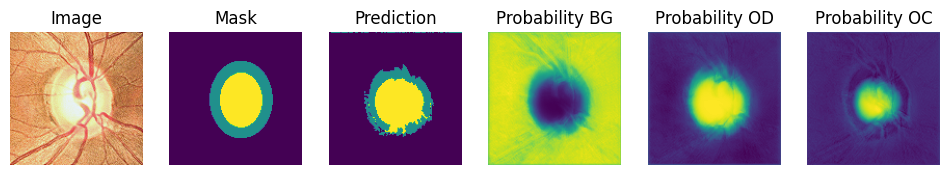

In [27]:
model = multilabel_model
criterion = ComboLoss(1)

for images, masks in loader2:
    images, masks = images.float(), masks.long()
    print(images.shape, masks.shape)
    preds, probs, loss = predict_multilabel(model, images, masks, device, criterion)
    print(preds.shape, probs.shape, loss)

    for i in range(images.shape[0]):
        img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        mask = masks[i].detach().cpu().numpy()
        pred = preds[i].detach().cpu().numpy()
        prob = probs[i].detach().cpu().numpy()

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 6, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 6, 2)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 6, 3)
        plt.imshow(pred)
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(1, 6, 4)
        plt.imshow(prob[0])
        plt.title('Probability BG')
        plt.axis('off')

        plt.subplot(1, 6, 5)
        plt.imshow(prob[1])
        plt.title('Probability OD')
        plt.axis('off')

        plt.subplot(1, 6, 6)
        plt.imshow(prob[2])
        plt.title('Probability OC')
        plt.axis('off')
    break